In [1]:
import os
os.chdir('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import torch
from torch import nn
import pickle
import textwrap
from math import ceil

import sklearn as sk
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor

import confseq
from confseq import predmix, conjmix_bounded, betting

from Energy_ds.dataset import DataPrep, DataModule, EnergyDataset
from Energy_ds.config import SEASON, REGION, DatasetConfig

from neural.train import LightningTrainer
from neural.module import LightningModel, LightningWrapper
from neural.mlp import MlpBlock, RMLP, MLPLayer
from neural.config import TrainConfig

import risk
from risk import Risk
from algorithm import Hypothesis, ConfSeq

pd.set_option('display.max_columns', None)
sns.set_palette('viridis')


In [2]:
class SubplotGenerator:
    def __init__(self, rows, columns, dpi=200, **kwargs):
        self.fig, self.axes = plt.subplots(rows, columns, dpi=dpi, **kwargs)
        self.rows = rows
        self.columns = columns
        self.current_row = 0
        self.current_col = 0

    def __iter__(self):
        self.current_row = 0
        self.current_col = 0
        return self

    def __next__(self) -> plt.Axes:
        if self.current_row >= self.rows:
            raise StopIteration
        ax = self.axes[self.current_row, self.current_col]
        self.current_col += 1
        if self.current_col >= self.columns:
            self.current_col = 0
            self.current_row += 1
        return ax
    
    @property
    def current_ax(self) -> plt.Axes:
        return self.axes[self.current_row, self.current_col]

In [3]:
class HoffConf(ConfSeq):
    def __init__(self, conf_lvl: float, min_val=None, max_val=None):
        super().__init__(conf_lvl, min_val, max_val)
    
    def calculate_cs(self, x):
        # min_val, max_val =  x.min(), x.max()
        # normalized = (x - min_val) / (max_val - min_val)
        lower_cs, higher_cs = predmix.predmix_hoeffding_cs(x, self.conf_lvl)

        # lower_cs = lower_cs * (max_val - min_val) + min_val
        # higher_cs = higher_cs * (max_val - min_val) + min_val
        return lower_cs, higher_cs
    
    @staticmethod
    def standardise(x):
        return (x - x.min()) / (x.max() - x.min())
    

class EmpbernConf(ConfSeq):
    def __init__(self, conf_lvl: float, min_val=None, max_val=None):
        super().__init__(conf_lvl, min_val=min_val, max_val=max_val)
    
    def calculate_cs(self, x):
        # min_val, max_val =  x.min(), x.max()
        # normalized = (x - min_val) / (max_val - min_val)

        lower_cs, higher_cs = predmix.predmix_empbern_twosided_cs(x, self.conf_lvl, running_intersection=False)

        # lower_cs = lower_cs * (max_val - min_val) + min_val
        # higher_cs = higher_cs * (max_val - min_val) + min_val
        return lower_cs, higher_cs
    

class EmpbernConjmix(ConfSeq):
    def __init__(self, conf_lvl: float, min_val=None, max_val=None):
        super().__init__(conf_lvl, min_val, max_val)
    
    def calculate_cs(self, x):
        # min_val, max_val =  x.min(), x.max()
        # normalized = (x - min_val) / (max_val - min_val)
        # std = x.std()
        lower_cs, higher_cs = conjmix_bounded.conjmix_empbern_twosided_cs(x, 1/12, self.conf_lvl)

        # lower_cs = lower_cs * (max_val - min_val) + min_val
        # higher_cs = higher_cs * (max_val - min_val) + min_val
        return lower_cs, higher_cs

class EmpbernBetting(ConfSeq):
    def __init__(self, conf_lvl: float, min_val=None, max_val=None):
        super().__init__(conf_lvl, min_val, max_val)
    
    def calculate_cs(self, x):
        # min_val, max_val =  x.min(), x.max()
        # normalized = (x - min_val) / (max_val - min_val)
        lower_cs, higher_cs = betting.betting_cs(x, self.conf_lvl)

        # lower_cs = lower_cs * (max_val - min_val) + min_val
        # higher_cs = higher_cs * (max_val - min_val) + min_val
        return lower_cs, higher_cs

In [4]:
class H0(Hypothesis):
    def __init__(self, tolerance:float, lower_bound:ConfSeq, upper_bound:ConfSeq):
        super().__init__(tolerance, lower_bound, upper_bound)
    
    @property
    def source_upper(self):
        return self.source_upper_cs[-1] * self.tolerance
    
    @property
    def target_lower(self):
        return self.target_lower_cs
    


In [5]:
class DeployedModel:
    def __init__(
        self,
        model: RandomForestRegressor,
        hyp_tests: list[tuple[Hypothesis, Risk]],
        past:int=np.inf
    ):
        self.model = model
        self.hyp_tests = hyp_tests
        self.past = past
        
        self.input_seq = None
        self.label_seq = None
        self.pred_seq = None

    def update(self, features:np.ndarray, labels: np.ndarray) -> bool:
        # features = features.reshape(-1, 1)
        preds = self.model.predict(features)
        # update input, label and prediction sequences
        self.input_seq = self._append_seq(features, self.input_seq)
        self.label_seq = self._append_seq(labels, self.label_seq)
        self.pred_seq = self._append_seq(preds, self.pred_seq)
        # update targed confidence bounds
        test_results = []
        for hyp, risk in self.hyp_tests:
            tr_input, tr_label, tr_pred, = self.input_seq, self.label_seq, self.pred_seq
            val = risk(tr_input, tr_label, tr_pred)
            if not np.isnan(val): # ignore nan values
                res = hyp.test(val)
                test_results.append(res)
        return all(test_results)

    def predict(self, x):
        return self.model.predict(x)

    def fit(self, x, y, batch_size:int=1):
        # fit model
        self.model = self.model.fit(x, y)
        # calibrate source confidence bounds
        preds = self.model.predict(x)
        for hyp, risk in self.hyp_tests:
            risk_list = []
            for i in range(0, len(x), batch_size):
                risk_list.append(risk(x[:i+1], y[:i+1], preds[:i+1]))

            risk_list = np.asanyarray(risk_list)
            risk_list = risk_list[~np.isnan(risk_list)]
            min_val, max_val = self.infer_bounds(hyp, risk_seq=risk_list, gamma=5, set_bounds=True)
            print(f"Inferred {risk} Bounds: min_val: {min_val}, max_val: {max_val}")
            hyp.calc_source_upper_cs(risk_list)
        
    def to_dataframe(self):
        results = []
        for hyp, risk in self.hyp_tests:
            res = hyp.to_dataframe()
            # res['GT'] = self.label_seq
            res['risk'] = risk.__class__.__name__
            res['hyp'] = hyp.__class__.__name__
            results.append(res)
        return pd.concat(results, axis=0, ignore_index=True)
    
    def _append_seq(self, x:np.ndarray|float, seq:np.ndarray, dim:int=0) -> np.ndarray:
        """
        append the input x to the sequence.
        parameters:
            x (np.ndarray): The input array of shape (n_samples) or a float if x is a single sample.
            seq (np.ndarray): The sequence to append to.
        """
        if isinstance(x, float):
            x = np.asanyarray([x])
        
        if seq is None:
            return x

        new_seq = np.concatenate((seq, x), axis=dim)
        return new_seq

    def reset(self, source:bool=True, target:bool=True):
        if target:
            self.input_seq = None
            self.label_seq = None
            self.pred_seq = None
        for hyp, risk in self.hyp_tests:
            hyp.reset(source=source, target=target)

    def infer_bounds(self, hyp:Hypothesis, risk_seq:np.ndarray, gamma:float=2, set_bounds:bool=False):
        std = (risk_seq).std()

        min_val = risk_seq.min() - std * gamma
        min_val = max(min_val, 0)
        # min_val = min(min_val * gamma, min_val / gamma)
        max_val = risk_seq.max() + std * gamma
        # max_val = max(max_val * gamma, max_val / gamma)

        if set_bounds:
            hyp.set_bounds(min_val, max_val)
        
        return min_val, max_val
    
    def seq_window(self, *seq:np.ndarray) -> tuple[np.ndarray]:
        """
        Get the sequence of the last n samples.
        """
        seq_list = []
        for s in seq:
            past = max(len(s) - self.past, 0)
            seq_list.append(s[past:])
            
        return seq_list
    
    def save(self, path:str, reset_source:bool=True, reset_target:bool=True):
        self.reset(source=reset_source, target=reset_target)
        with open(path, 'wb') as f:
            pickle.dump(self, f)
    
    @staticmethod
    def load(path:str) -> 'DeployedModel':
        with open(path, 'rb') as f:
            return pickle.load(f)
        
    

In [6]:
class Experiment:
    def __init__(
        self,
        model,
        # train_ds,
        # test_ds,
        test_batch_size=1,
    ):
        self.model: DeployedModel = model
        # self.train_ds: EnergyDataset = train_ds
        # self.test_ds: EnergyDataset = test_ds
        self.test_batch_size: int = test_batch_size

    def train(self, train_ds: EnergyDataset):
        self.model.fit(train_ds.features, train_ds.labels, batch_size=self.test_batch_size)
    
    def eval(self, val_ds: EnergyDataset):
        preds = self.model.predict(val_ds.features)
        mse = sk.metrics.mean_squared_error(val_ds.labels, preds)
        mae = sk.metrics.mean_absolute_error(val_ds.labels, preds)
        return mse, mae

    def test(self, test_ds: EnergyDataset):
        ds_len = len(test_ds)
        for i in range(0, ds_len, self.test_batch_size):
            # prepare batch
            batch_end = min(i+self.test_batch_size, ds_len)
            x = test_ds.features[i:batch_end]
            y = test_ds.labels[i:batch_end]
            # print(f"batch {i} :: x.shape={x.shape}, y.shape={y.shape}")
            # predict
            result = self.model.update(x, y)

        return self.model.to_dataframe()

In [7]:
path = "Hourly_Energy_Consumption/AEP_hourly.csv"
all_paths = ['Hourly_Energy_Consumption/AEP_hourly.csv',
            'Hourly_Energy_Consumption/COMED_hourly.csv',
            'Hourly_Energy_Consumption/DAYTON_hourly.csv',
            'Hourly_Energy_Consumption/DEOK_hourly.csv',
            'Hourly_Energy_Consumption/DOM_hourly.csv',
            'Hourly_Energy_Consumption/DUQ_hourly.csv',
            'Hourly_Energy_Consumption/EKPC_hourly.csv',
            'Hourly_Energy_Consumption/FE_hourly.csv',
            # 'Hourly_Energy_Consumption/NI_hourly.csv',
            'Hourly_Energy_Consumption/PJME_hourly.csv',
            'Hourly_Energy_Consumption/PJMW_hourly.csv',
            # 'Hourly_Energy_Consumption/PJM_Load_hourly.csv',
            # 'Hourly_Energy_Consumption/est_hourly.paruqet',
            # 'Hourly_Energy_Consumption/pjm_hourly_est.csv'
            ]

# Analyze Data

In [8]:
prep = DataPrep(*all_paths)
data = prep.data

In [9]:
data['Region'] = data['Region'].apply(lambda x: REGION(x).name)
data['Epoch'] = data['Datetime'].apply(lambda x: x.timestamp())
grouped = data.groupby(by=['Region']).agg(['min', 'max', 'mean', 'std'])
grouped


Datetime                                           \
                       min        max                          mean   
Region                                                                
AEP    2004-10-01 01:00:00 2018-08-03 2011-09-02 03:17:01.553025024   
COMED  2011-01-01 01:00:00 2018-08-03 2014-10-17 14:11:46.389762048   
DAYTON 2004-10-01 01:00:00 2018-08-03 2011-09-02 03:33:26.471243008   
DEOK   2012-01-01 01:00:00 2018-08-03 2015-04-18 01:50:20.461040128   
DOM    2005-05-01 01:00:00 2018-08-03 2011-12-17 03:06:26.928194560   
DUQ    2005-01-01 01:00:00 2018-08-03 2011-10-18 03:17:46.200826368   
EKPC   2013-06-01 01:00:00 2018-08-03 2016-01-01 12:59:54.679490048   
FE     2011-06-01 01:00:00 2018-08-03 2015-01-01 01:57:54.549097984   
PJME   2002-01-01 01:00:00 2018-08-03 2010-04-18 03:25:25.999202048   
PJMW   2002-04-01 01:00:00 2018-08-03 2010-06-02 03:39:50.656816128   

                                          MW                         \
                                std      min      max          mean   
Region                                                                
AEP    1459 days 00:04:35.416530256   9581.0  25695.0  15499.513717   
COMED   799 days 21:58:33.102316120   7237.0  23753.0  11420.152112   
DAYTON 1458 days 23:51:35.157888992    982.0   3746.0   2037.851140   
DEOK    694 days 13:03:11.442351240    907.0   5445.0   3105.096486   
DOM    1397 days 19:15:23.708513376   1253.0  21651.0  10949.203625   
DUQ    1432 days 10:34:50.462659536   1014.0   3054.0   1658.820296   
EKPC    545 days 07:12:02.646685136    514.0   3490.0   1464.218423   
FE      756 days 07:49:31.117741040      0.0  14032.0   7792.159064   
PJME   1748 days 20:09:48.026926592  14544.0  62009.0  32080.222831   
PJMW   1722 days 20:27:36.657026176    487.0   9594.0   5602.375089   

                     Year                              Month                \
                std   min   max         mean       std   min max      mean   
Region                                                                       
AEP     2591.399065  2004  2018  2011.169988  4.011177     1  12  6.500309   
COMED   2304.139517  2011  2018  2014.309172  2.197997     1  12  6.332586   
DAYTON   393.403153  2004  2018  2011.170019  4.011153     1  12  6.500326   
DEOK     599.859026  2012  2018  2014.811098  1.910792     1  12  6.303261   
DOM     2413.946569  2005  2018  2011.459088  3.845824     1  12  6.514025   
DUQ      301.740640  2005  2018  2011.302911  3.926464     1  12  6.416989   
EKPC     378.868404  2013  2018  2015.500375  1.543446     1  12  6.525345   
FE      1331.268006  2011  2018  2014.499857  2.107653     1  12  6.523778   
PJME    6464.012166  2002  2018  2009.801026  4.791823     1  12  6.435948   
PJMW     979.142872  2002  2018  2009.918691  4.730344     1  12  6.502835   

                 Day                          Hour                           \
             std min max       mean       std  min max       mean       std   
Region                                                                        
AEP     3.461454   1  31  15.723220  8.802246    0  23  11.501587  6.921830   
COMED   3.424633   1  31  15.715656  8.803733    0  23  11.500880  6.922073   
DAYTON  3.461476   1  31  15.723100  8.802228    0  23  11.501546  6.921810   
DEOK    3.420165   1  31  15.714699  8.804815    0  23  11.500701  6.922139   
DOM     3.417708   1  31  15.725869  8.803861    0  23  11.501459  6.921836   
DUQ     3.436416   1  31  15.721117  8.801321    0  23  11.501495  6.921829   
EKPC    3.392182   1  31  15.713416  8.807696    0  23  11.500309  6.922271   
FE      3.408244   1  31  15.720982  8.806671    0  23  11.500795  6.922095   
PJME    3.438946   1  31  15.723161  8.801210    0  23  11.501596  6.921794   
PJMW    3.419536   1  31  15.726024  8.802522    0  23  11.501620  6.921789   

       Week_Number                           Season                          \
               min max       mean        std    

In [10]:
# g = sns.relplot(data=data, x='Datetime', y='MW', hue='Region', kind='line', aspect=3, linewidth = 0.8)
# g.figure.suptitle(template=f"Energy Consumption in each region, by season")
# g.figure.set_dpi(200)

![Dataset Visualization](/home/guycoh/new/ReliabilityInML_Project/imgs/dataset_vis.png)

Text(0.5, 1.0, 'ds_config:region=[<REGION.AEP: 1>, <REGION.COMED: 2>, <REGION.DOM: 5>], years=(2011, 2015), days=[1], ')

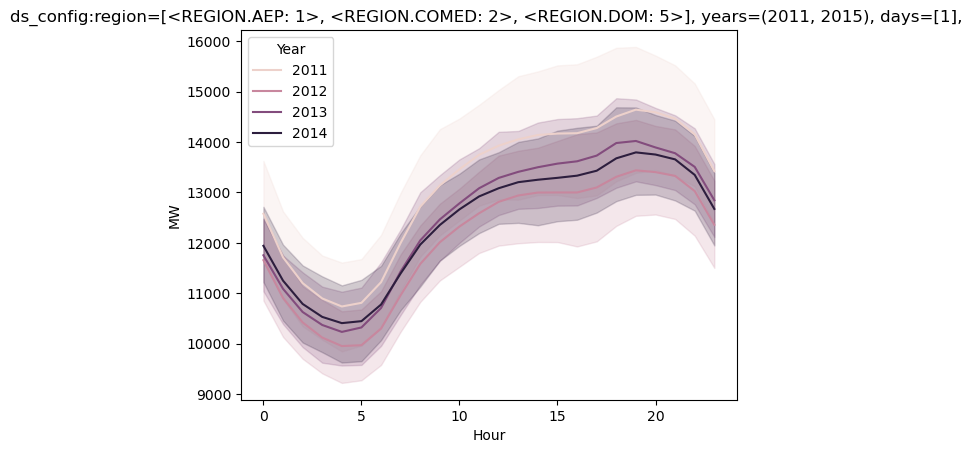

In [11]:
train_config = DatasetConfig(
    # past_hours=[1,2,3,6, 12, 24, 36],
    years=(2011, 2015),
    # months=[1],
    days=[1],
    region=[REGION.AEP, REGION.COMED, REGION.DOM],
    # season=None,
)

train_ds = EnergyDataset(all_paths, train_config)
train_ds.features_df
data = pd.concat([train_ds.features_df, train_ds.labels_df], axis=1)
data['Season'] = data['Season'].apply(lambda x: SEASON(x).name)
data['Region'] = data['Region'].apply(lambda x: REGION(x).name)


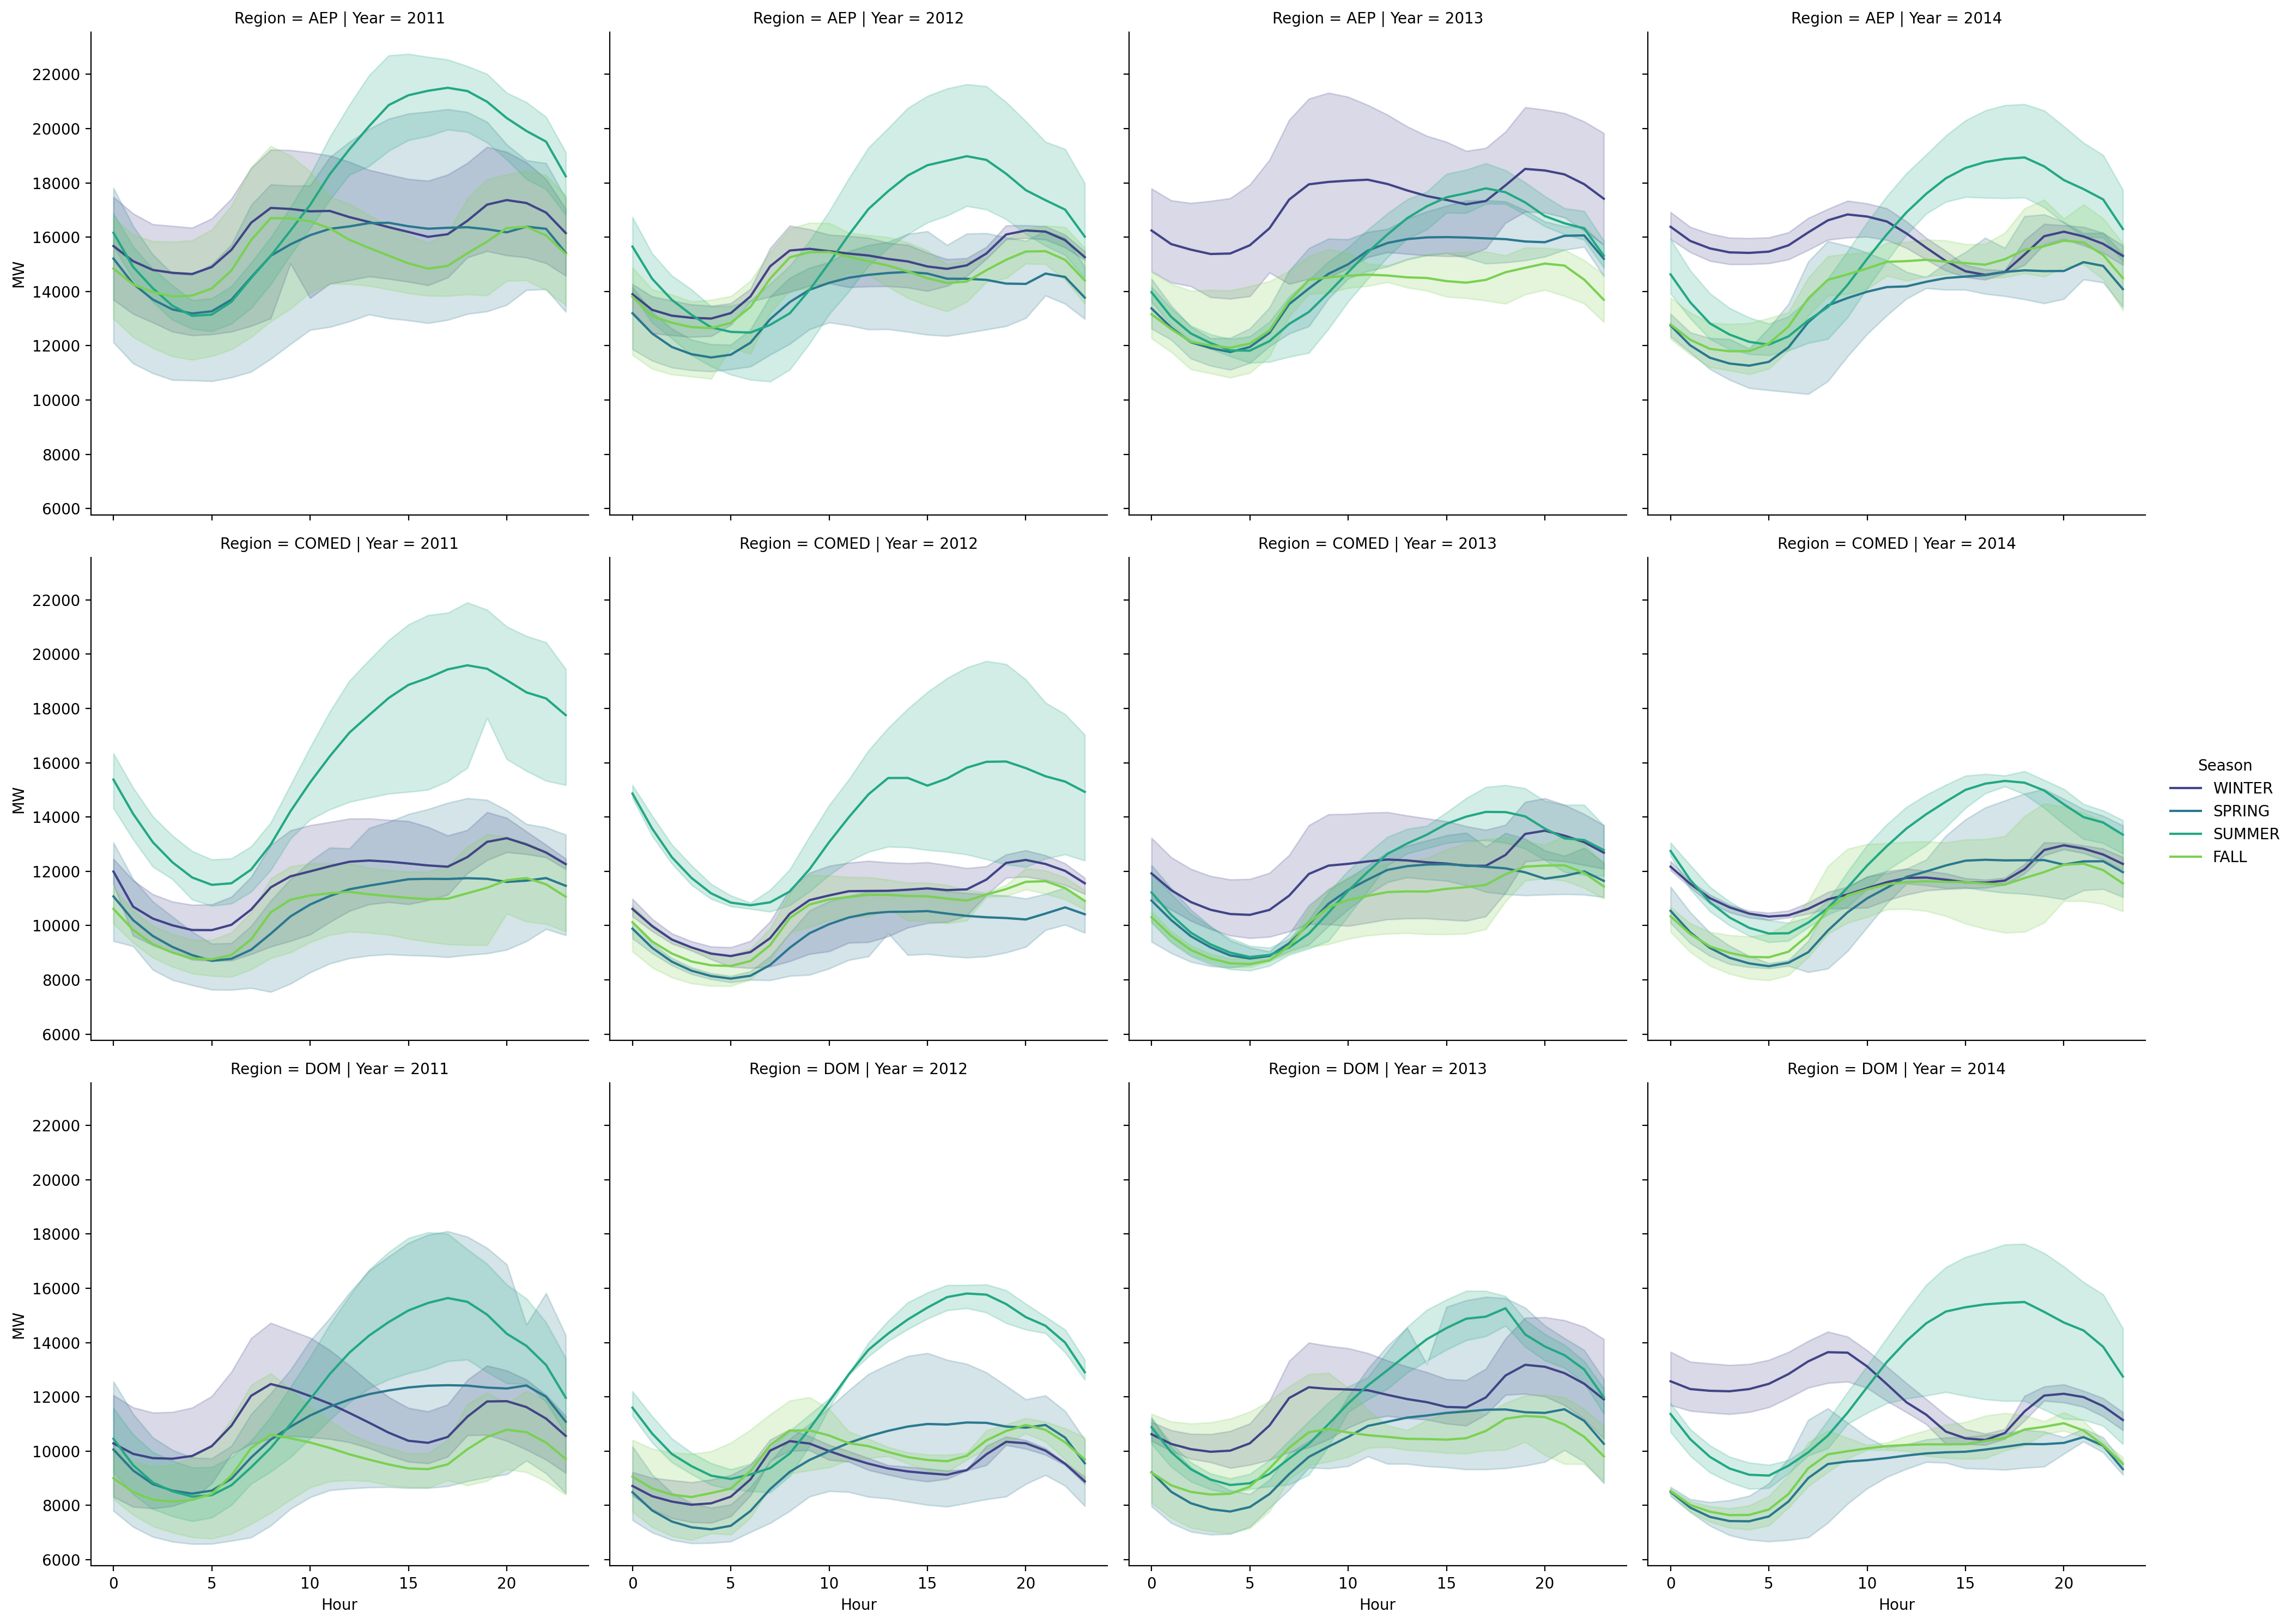

In [12]:
g = sns.relplot(data=data, x='Hour', y='MW', hue='Season', col='Year', row='Region', kind='line', palette='viridis')
g.figure.set_dpi(200)

# Run Experiments

In [13]:
train_config = DatasetConfig(
    past_hours=[1,2,3,6, 12, 24, 36],
    years=(2011, 2015),
    region=[REGION.AEP, REGION.COMED, REGION.DOM],
    # season=None,
)

# test_config = DatasetConfig(
#     past_hours=[-1, -12, -24, -36],
#     years=(2014, 2019),
#     region=[REGION.AEP],
#     season=SEASON.WINTER,
# )

# test_config_ood = DatasetConfig(
#     past_hours=[-1, -12, -24, -36],
#     years=(2011, 2013),
#     region=[REGION.AEP],
#     season=SEASON.SUMMER,
# )

In [14]:
print(train_config.__dict__)

{'past_hours': [1, 2, 3, 6, 12, 24, 36], 'region': [<REGION.AEP: 1>, <REGION.COMED: 2>, <REGION.DOM: 5>], 'years': (2011, 2015), 'season': None, 'months': None, 'days': None}


In [15]:
train_ds = EnergyDataset(all_paths, train_config)
# test_ds = EnergyDataset(all_paths, test_config)
# test_ds_ood = EnergyDataset(all_paths, test_config_ood)

columns = train_ds.features_df.columns

In [16]:
train_ds.features_df.describe()

,Region,Year,Month,Day,Hour,Week_Number,Season,MW_at_-1H,MW_at_-2H,MW_at_-3H,MW_at_-6H,MW_at_-12H,MW_at_-24H,MW_at_-36H
count,105171.000000,105171.000000,105171.000000,105171.000000,105171.000000,105171.0,105171.000000,105171.000000,105171.000000,105171.000000,105171.000000,105171.000000,105171.000000,105171.000000
mean,2.666705,2012.499748,6.523110,15.731067,11.501669,26.483118,2.491210,12603.652338,12603.634966,12603.624944,12603.616700,12603.744711,12603.617033,12603.947077
std,1.699689,1.117754,3.448592,8.800323,6.921809,15.056221,1.117056,3113.304386,3113.295210,3113.293906,3113.308066,3113.532533,3113.316371,3113.520589
min,1.000000,2011.000000,1.000000,1.000000,0.000000,1.0,1.000000,5518.000000,5518.000000,5518.000000,5518.000000,5518.000000,5518.000000,5518.000000
25%,1.000000,2012.000000,4.000000,8.000000,6.000000,13.0,1.000000,10200.000000,10200.000000,10200.000000,10200.000000,10200.000000,10200.000000,10200.000000
50%,2.000000,2012.000000,7.000000,16.000000,12.000000,26.0,2.000000,12134.000000,12134.000000,12134.000000,12134.000000,12134.000000,12134.000000,12134.000000
75%,5.000000,2013.000000,10.000000,23.000000,18.000000,40.0,3.000000,14701.500000,14701.500000,14702.000000,14702.000000,14702.000000,14702.000000,14702.000000
max,5.000000,2014.000000,12.000000,31.000000,23.000000,52.0,4.000000,24597.000000,24597.000000,24597.000000,24597.000000,24597.000000,24597.000000,24597.000000


In [17]:
from sklearn.neural_network import MLPRegressor

# rf = RandomForestRegressor(
#     n_estimators=150,
#     min_samples_split=0.05,
#     min_samples_leaf=0.05,
#     n_jobs=-1,
#     random_state=42,
#     verbose=1,
# )

# rf = GradientBoostingRegressor(
#     loss='squared_error',
#     learning_rate=0.1,
#     n_estimators=100,
#     min_samples_split=0.05,
#     min_samples_leaf=0.05,
#     max_depth=5,
#     random_state=42,
#     # n_iter_no_change=5,
#     verbose=1,
# )

# rf = AdaBoostRegressor(
#     estimator=rf,
#     n_estimators=100,
#     learning_rate=1,
#     loss='square',
#     random_state=42,
# )

rf = ExtraTreesRegressor(
    n_estimators=400,
    min_samples_split=0.03,
    min_samples_leaf=0.03,
    n_jobs=-1,
    random_state=42,
    # verbose=1,
)

# rf = MLPRegressor(
#     hidden_layer_sizes=(50, 50, 25),
#     activation='relu',
#     learning_rate='adaptive',
#     max_iter=100,
#     shuffle=False,
#     random_state=42,
#     verbose=True,
# )

In [18]:
class RiskFilter2(risk.RiskFilter):
    def __init__(self, risk:Risk, feature_cols:list[str], cfg:DatasetConfig, name:str=''):
        self.config = cfg
        super().__init__(risk, feature_cols, self.config.conditions, name)

In [19]:
tests = []

min_val = 0 #train_ds.labels.min()
max_val = train_ds.labels.max() * 2


mae_risk = risk.MAE()
hyp_test_1 = H0(tolerance=1.1,
                lower_bound=EmpbernConjmix(0.05),
                upper_bound=EmpbernConjmix(0.05)
                )
tests.append((hyp_test_1, mae_risk))

# quantile_risk = risk.Quantile(0.8)
# hyp_test_2 = H0(tolerance=1.1,
#                 lower_bound=EmpbernConjmix(0.05),
#                 upper_bound=EmpbernConjmix(0.05)
#                 )
# tests.append((hyp_test_2, quantile_risk))
# def season_filter(season:SEASON):
#     def filter_sesaon(df):
#         return df['Season']==season.value
#     return filter_sesaon

for season in SEASON:
    conf = DatasetConfig(season=[season])
    
    mae = risk.MAE()

    filter_risk = RiskFilter2(mae, columns, conf, name=season.name)
    hyp_test_3 = H0(tolerance=1.1,
                    lower_bound=EmpbernConjmix(0.05),
                    upper_bound=EmpbernConjmix(0.05)
                    )
    tests.append((hyp_test_3, filter_risk))

In [20]:
model = DeployedModel(rf, tests, past=24*30)

In [21]:
experiment = Experiment(model, test_batch_size=24*7)

In [22]:
experiment.model.reset(source=True, target=True)

In [23]:
train_ds.features_df

,Region,Year,Month,Day,Hour,Week_Number,Season,MW_at_-1H,MW_at_-2H,MW_at_-3H,MW_at_-6H,MW_at_-12H,MW_at_-24H,MW_at_-36H
0,1,2011,1,1,0,52,4,14089.0,14450.0,14807.0,15266.0,15382.0,15474.0,17481.0
1,1,2011,1,1,1,52,4,13694.0,14089.0,14450.0,15444.0,14972.0,14695.0,16992.0
2,1,2011,1,1,2,52,4,13172.0,13694.0,14089.0,15127.0,14483.0,14290.0,16497.0
3,1,2011,1,1,3,52,4,12856.0,13172.0,13694.0,14807.0,14263.0,13992.0,16241.0
4,1,2011,1,1,4,52,4,12516.0,12856.0,13172.0,14450.0,14098.0,13896.0,15860.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105166,5,2014,12,31,19,1,4,13850.0,12449.0,11878.0,12509.0,14379.0,13813.0,11883.0
105167,5,2014,12,31,20,1,4,14057.0,13850.0,12449.0,12066.0,14735.0,13860.0,12479.0
105168,5,2014,12,31,21,1,4,13987.0,14057.0,13850.0,11875.0,14573.0,13814.0,12611.0
105169,5,2014,12,31,22,1,4,13759.0,13987.0,14057.0,11878.0,14233.0,13576.0,12722.0


In [24]:
train_ds.labels_df

0         13694.0
1         13172.0
2         12856.0
3         12516.0
4         12380.0
           ...   
105166    14057.0
105167    13987.0
105168    13759.0
105169    13454.0
105170    13140.0
Name: MW, Length: 105171, dtype: float64

In [25]:
experiment.train(train_ds)
experiment.eval(train_ds)

Inferred MAE Bounds: min_val: 234.89548981830688, max_val: 1056.9258092560651
Inferred RiskFilter:SPRING Bounds: min_val: 279.3429958361235, max_val: 622.4573545089825
Inferred RiskFilter:SUMMER Bounds: min_val: 236.90800243622925, max_val: 1612.683018519119
Inferred RiskFilter:FALL Bounds: min_val: 272.96763803472817, max_val: 564.7117803753147
Inferred RiskFilter:WINTER Bounds: min_val: 127.88705334465664, max_val: 1121.4884482520963


(446204.99200648273, 492.12703034492375)

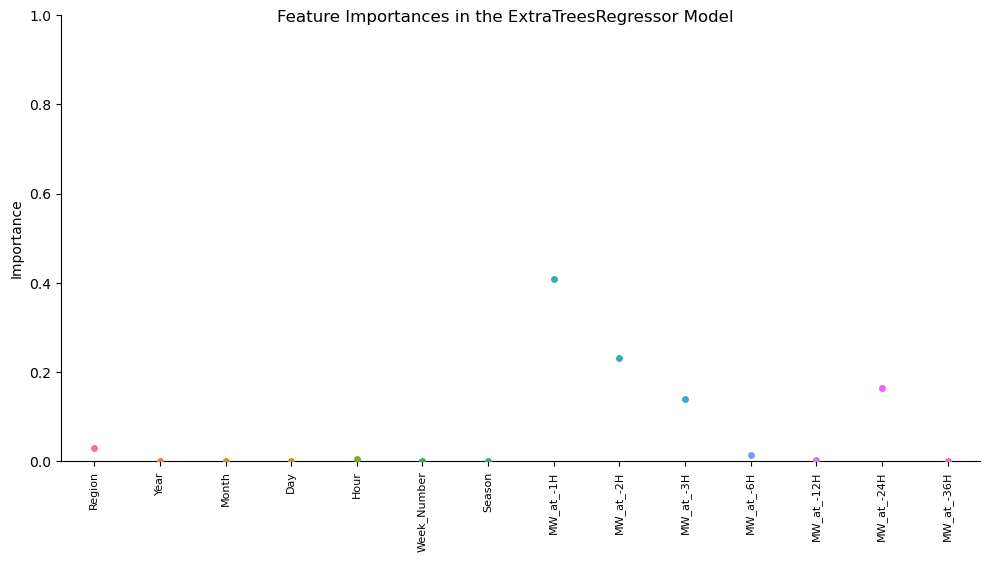

In [26]:
# Show feature inportances
feature_cols = train_ds.features_df.columns
featureimportances = pd.DataFrame(experiment.model.model.feature_importances_.reshape(1,-1), columns=feature_cols)
# fig, ax = plt.subplots(dpi=200, figsize=(10, 5))
g = sns.catplot(data=featureimportances, aspect=2)
g.set_xticklabels(rotation=90, fontsize=8)
g.figure.suptitle(f"Feature Importances in the {experiment.model.model.__class__.__name__} Model")
g.set_ylabels("Importance")
g.set(ylim=(0, 1))

In [63]:
def run_experiment(experiment:Experiment, ds:EnergyDataset, n_cols:int=3, **kwargs):
    config = ds.config
    experiment.model.reset(source=False, target=True)
    result = experiment.test(ds)
    n_rows = ceil(len(experiment.model.hyp_tests) / n_cols)
    plot_gen = SubplotGenerator(n_rows, n_cols, figsize=(10*n_cols, 7*n_rows))
    fig: plt.Figure = plot_gen.fig
    # fig.set_figwidth(15, forward=True)
    # fig.set_figheight(10, forward=True)

    for (hyp, test_risk), ax in zip(experiment.model.hyp_tests, plot_gen):
        # ax = ax_gen.__next__()
        g = hyp.plot(layout='constrained', ax=ax, **kwargs)
        title = f"Tolerance: {hyp.tolerance}, Risk={test_risk}"
        title = textwrap.fill(title, width=100)
        conf = textwrap.fill(str(config), width=100)
        g.set_title(title + '\n' + conf, fontsize=10)
        g.legend(fontsize=8)  # Adjust legend font size and position

        g.autoscale(enable=True, axis='both')
    return result

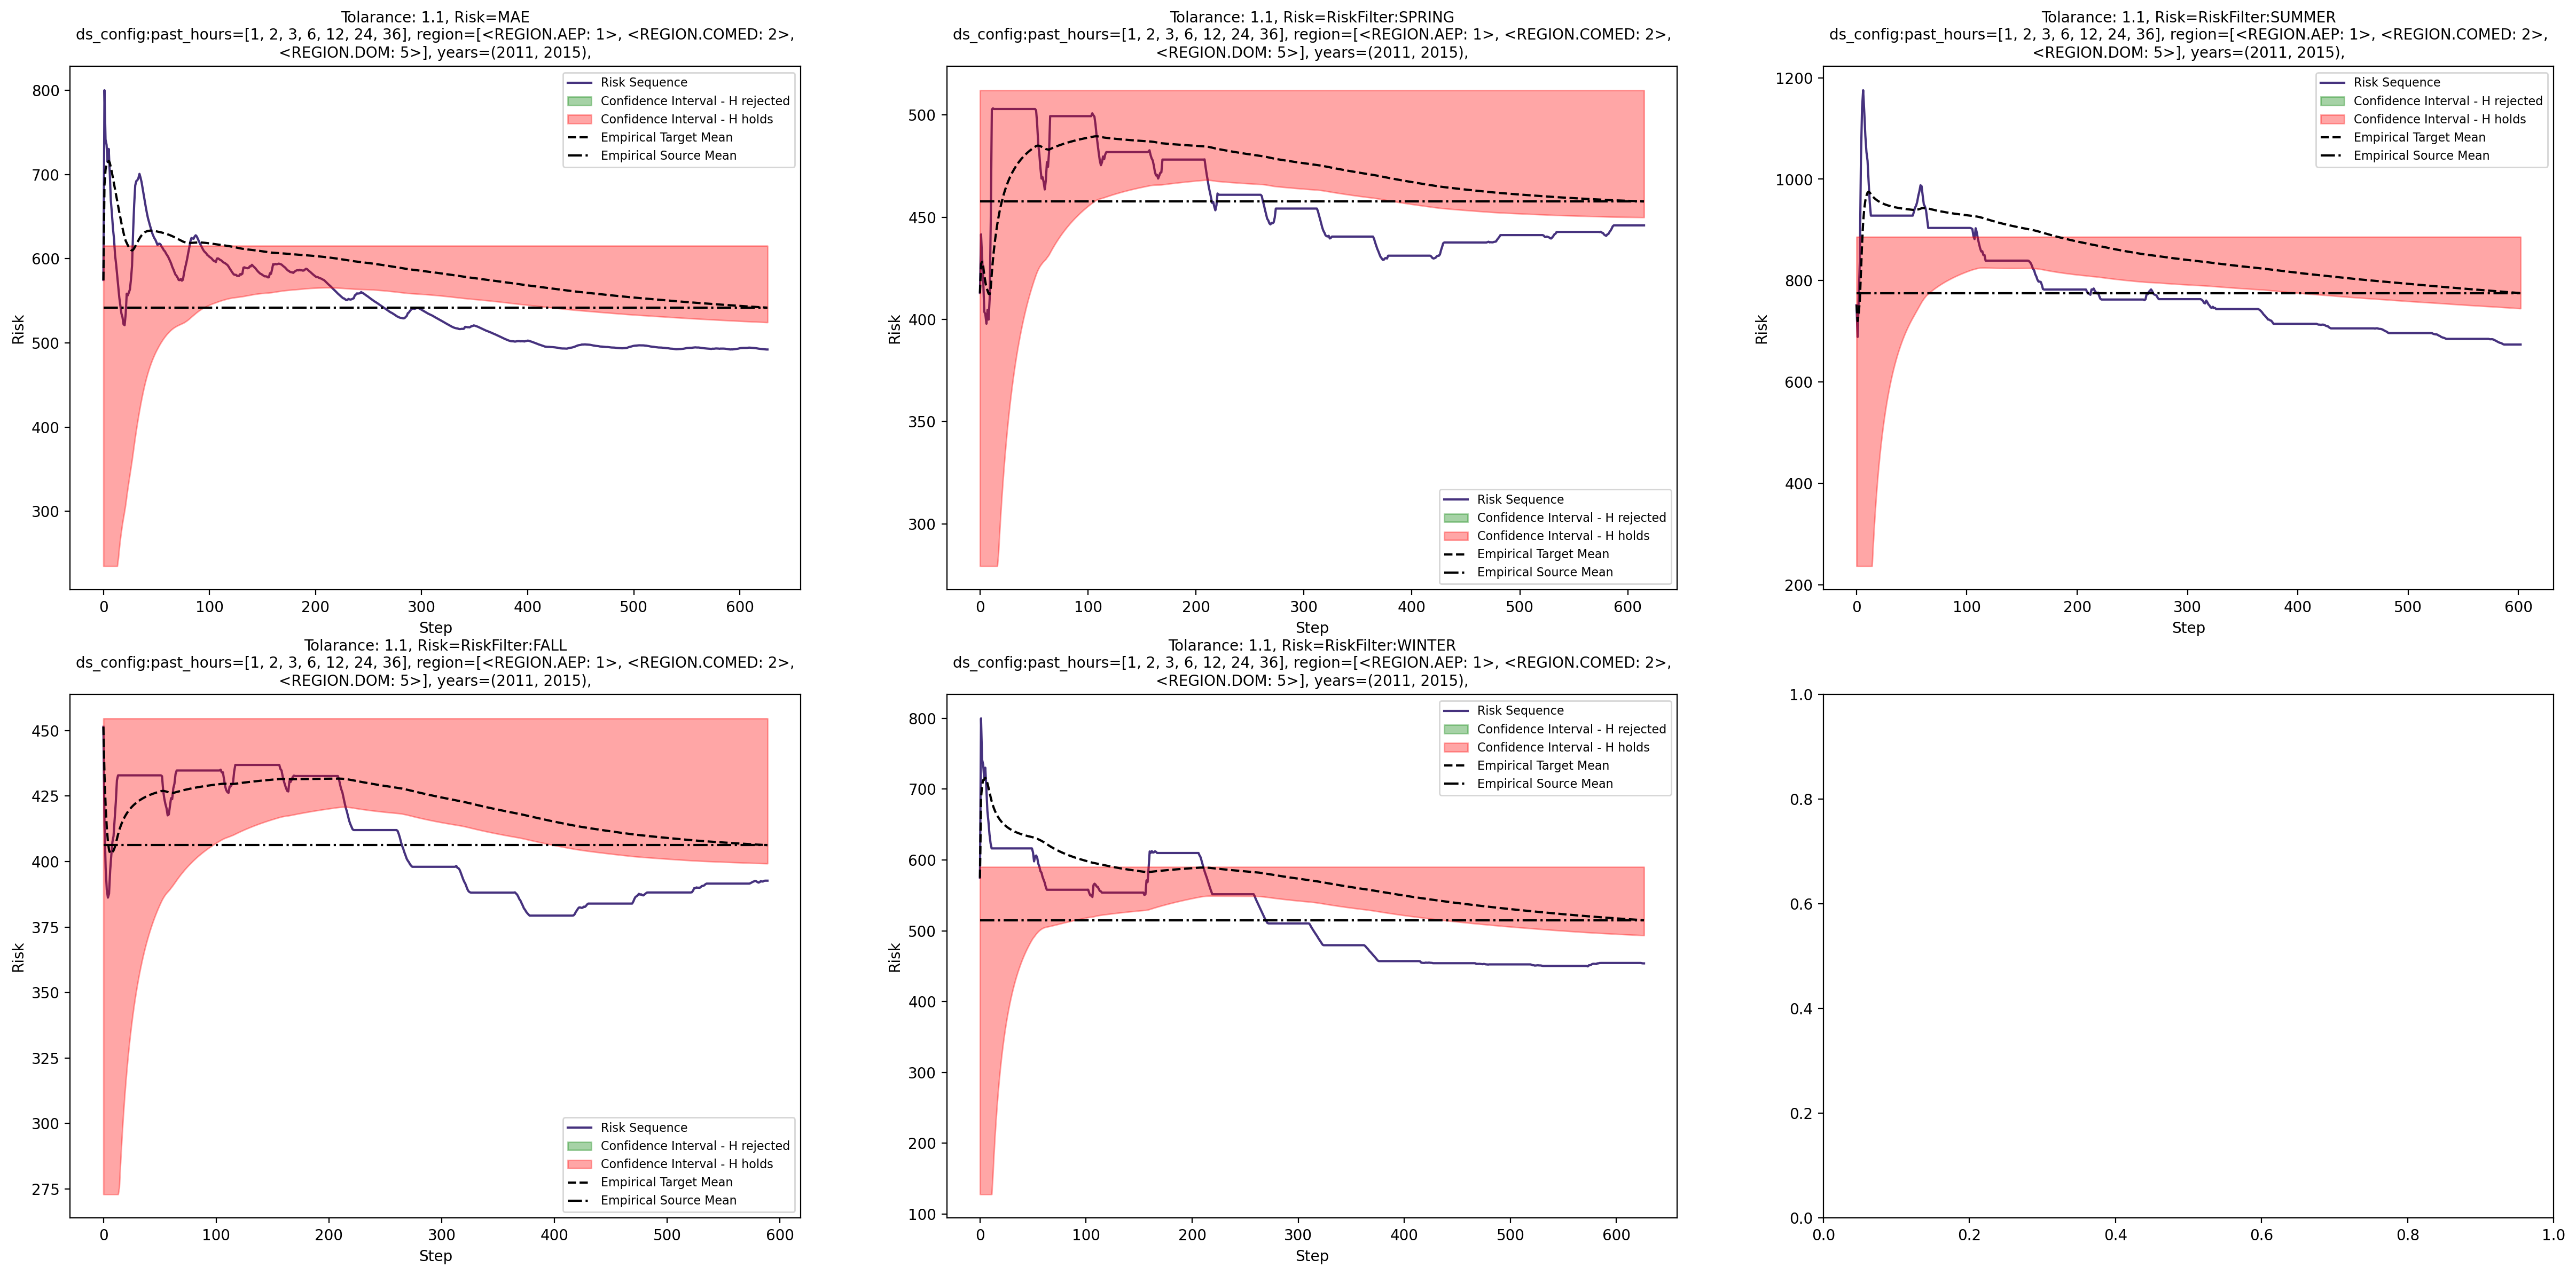

In [65]:
test_result = run_experiment(experiment, train_ds)

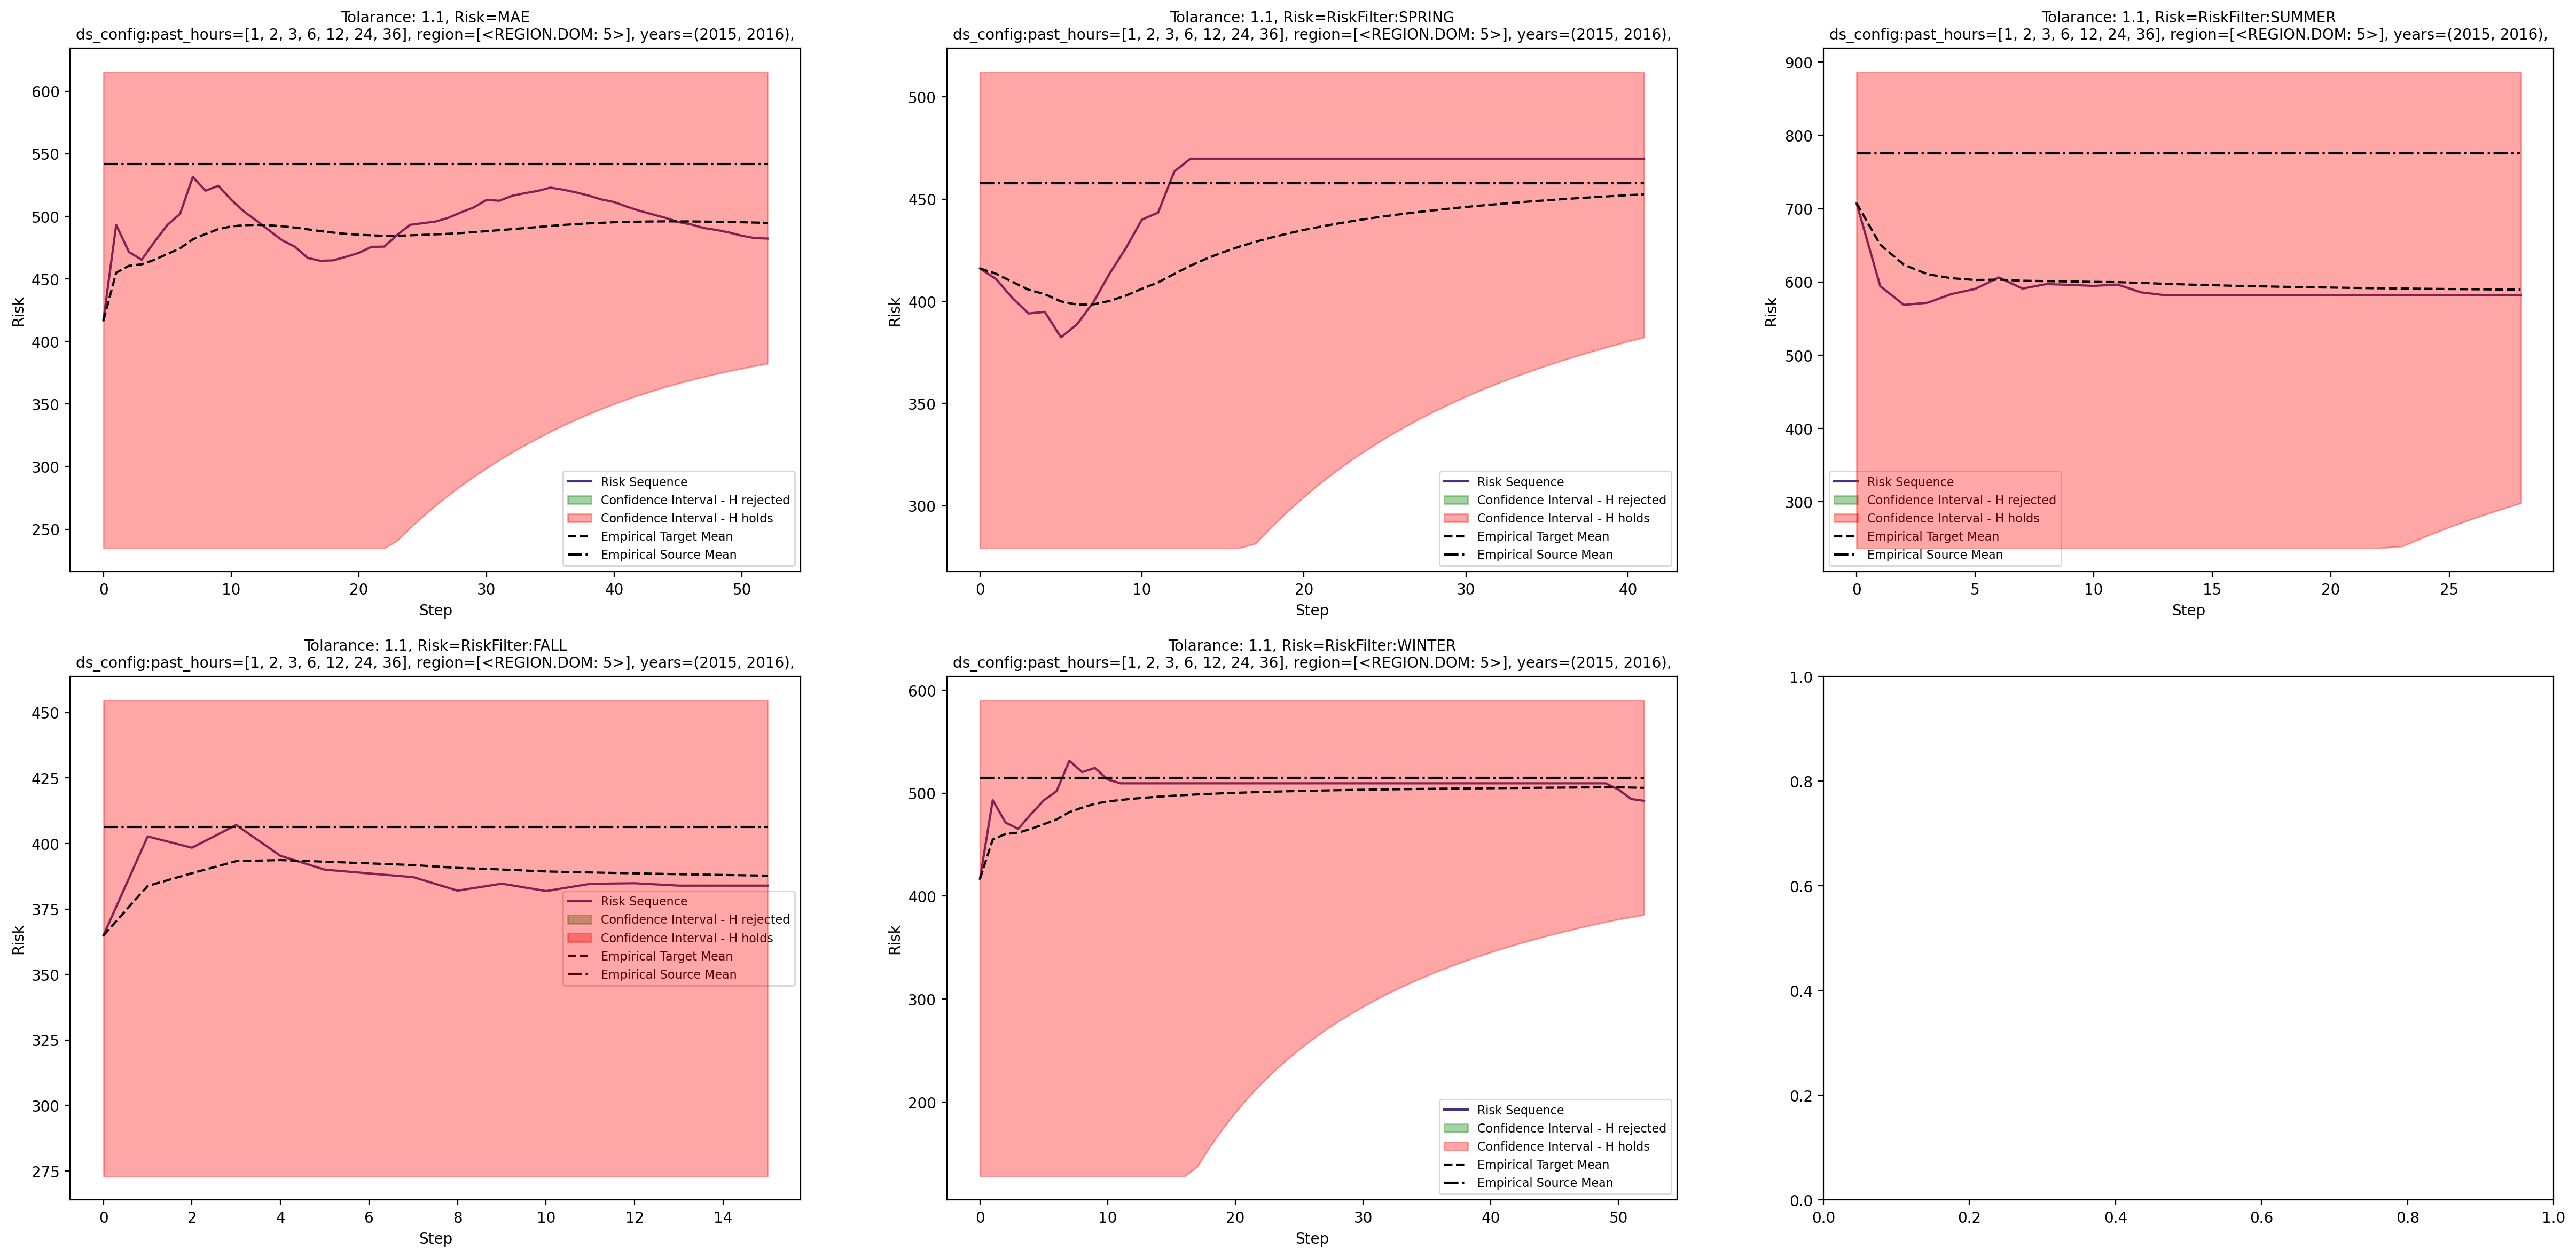

In [64]:
test_cfg = DatasetConfig(**train_config.__dict__)
test_cfg.region = [REGION.DOM]
test_cfg.years = (2015, 2016)
test_ds = EnergyDataset(all_paths, test_cfg)
test_result = run_experiment(experiment, test_ds)

In [ ]:
# experiment.model.hyp_tests[0][0].plot()
# ax_gen_list = [SubplotGenerator(3, 2) for _ in range(len(model.hyp_tests))]
print("Train Config:")
print(train_config.__dict__)
for season in list(SEASON):
    config = DatasetConfig(**train_config.__dict__)
    config.season = [season] if season is not None else None
    # config.years = (2014, 2019)
    print("Test Config:")
    print(config)
    dataset = EnergyDataset(all_paths, config)
    print(dataset.features_df.shape)
    result = run_experiment(experiment, dataset)
    plt.show()
    # result = experiment.test(dataset)
    # for hyp, test_risk in experiment.model.hyp_tests:
    #     # ax = ax_gen.__next__()
    #     g = hyp.plot(layout='constrained')
    #     g.set_title(f"Tolarance: {hyp.tolerance}, Risk={test_risk}, Season={config.season}", fontsize=10)
    #     g.legend(fontsize=8)  # Adjust legend font size and position

    #     g.autoscale(enable=True, axis='both')
    #     plt.show()
    
    # experiment.model.reset(source=False, target=True)

# plt.tight_layout(pad=2,rect=[0.1, 0.1, 0.9, 0.9])
plt.show()

In [30]:
experiment.model.reset(source=False, target=True)

In [ ]:
import time
while True:
    time.sleep(1)

# OLD

In [2]:
settings = TrainConfig(
        # loss_fn = 'bce', # str
        # optimizer = 'adam', # str
        device = f"gpu", # str
        log = False, # bool
        logs_dir = "logs/", # str
        num_epochs = 30, # int
        checkpoints = 'test.pt', # str
        early_stopping = None, # int
        log_every = 1, # int
        timeout = "00:12:00:00", # int
        # learning_rate = 0.001, # float
        # weight_decay = 1e-06, # float
        batch_size = 2048, # int
        shuffle = False, # bool
        num_workers = 9, # int
        # train_test_split = 0.5, # float
    )

In [ ]:
path = "Hourly_Energy_Consumption/AEP_hourly.csv"
past_hours = 2

prper = DataPrep(path)
data = prper.data

# train_years = range(2004, 2016)
# val_years = range(2016, 2018)

def year_cond(start:int, end:int):
    return lambda data: data['Year'].between(start, end)

def season_cond(season:SEASON):
    return lambda data: data['Season'] == season.value

def month_cond(month:int):
    return lambda data: data['Month'] == month

def cond_and(conds:list):
    def cond(data):
        mask = pd.Series(len(data)*[True])
        for c in conds:
            mask = mask & c(data)
        return mask
    # return lambda data: ([cond(data) for cond in conds])
    return cond

train_conds = [year_cond(2006, 2008), season_cond(SEASON.WINTER)]
val_conds = [year_cond(2009, 2012), season_cond(SEASON.SUMMER)]

train_ds = EnergyDataset(path, past_hours=past_hours, condition=cond_and(train_conds))
val_ds = EnergyDataset(path, past_hours=past_hours, condition=cond_and(val_conds))


datamodule = DataModule(train_ds,
                        val_ds,
                        batch_size=settings.batch_size,
                        num_workers=settings.num_workers,
                        shuffle=settings.shuffle,
                        seed=42,
                        )


In [ ]:
train_ds.labels_df

In [ ]:
train_ds.data_df

In [ ]:
train_ds[0]

In [9]:
# datamodule.prepare_data()
dl = datamodule.train_dataloader()

In [10]:
batch, label = next(iter(dl))
n_features = batch.shape[-1]

In [ ]:
batch.shape, label.shape

In [31]:
from torch import Tensor


class ResidMLP(LightningModel):
    def __init__(self, input_size, hidden_size, output_size=1, loss:nn.Module=nn.L1Loss()):
        super().__init__(loss)
        # self.f = nn.TransformerEncoderLayer(input_size,
        #                                     nhead=4,
        #                                     dim_feedforward=hidden_size[-1],
        #                                     dropout=0.1,
        #                                     activation='relu',
        #                                     batch_first=True)
        
        # self.rmlp = RMLP(
        #     in_dim=input_size,
        #     block_in_dim=hidden_size[0], 
        #     block_dims=hidden_size,
        #     block_nonlins=[nn.ReLU()]*len(hidden_size),
        #     n_blocks=2,
        #     out_dim=output_size,
        #     out_nonlin=nn.Identity(),
        #     batch_norm=False,
        #     )
        # self.mlp = MlpBlock(
        #     in_dim=input_size,
        #     dims=hidden_size,
        #     nonlins=[nn.Tanh()]*len(hidden_size),
        #     batch_norm=False,
        #     )
        self.out_layer = nn.Linear(input_size, output_size)
    
    def forward(self, x):
        # x = x.flatten(1).to(torch.float32)
        # x = self.rmlp(x)
        # x = self.mlp(x)
        # x = self.f(x)
        return self.out_layer(x)#.squeeze(-1)
    
    def accuracy(self, preds: Tensor, labels: Tensor) -> Tensor:
        return (preds - labels).abs().mean()
    


In [ ]:
in_size = n_features#*past_hours
rmlp = ResidMLP(input_size=in_size, hidden_size=[24, 16], output_size=1)

model = LightningWrapper(rmlp)
print(model)

In [ ]:
trainer = LightningTrainer(settings, "global_wheat_1")
train_dl, val_dl = datamodule.train_dataloader(), datamodule.val_dataloader()
trainer.fit(model, dl_train=train_dl, dl_test=val_dl)


In [10]:
import sklearn as sk
from sklearn.ensemble import RandomForestRegressor

In [11]:
rf = RandomForestRegressor()


In [12]:
rf = rf.fit(train_ds.features, train_ds.labels)

In [13]:
def mae(preds, labels):
    return np.abs(preds - labels).mean()

In [17]:
train_scores = mae(rf.predict(train_ds.features), train_ds.labels.numpy())
val_scores = mae(rf.predict(val_ds.features), val_ds.labels.numpy())

In [69]:

def validate(model:RandomForestRegressor, val_dl):
    scores = []
    for batch, label in val_dl:
        score = np.abs(model.predict(batch.numpy()) - label.numpy()).flatten()
        scores.append(score)
    return np.concatenate(scores)

train_scores = validate(rf, train_dl)
val_scores = validate(rf, val_dl)
# scores = []
# for batch, label in val_dl:
#     score = np.abs(rf.predict(batch.numpy()) - label.numpy()).mean()
#     scores.append(score)
# print(np.mean(scores))

In [ ]:
print(f"train_score = {train_scores.mean()}")
print(f"val_score = {val_scores.mean()}")

In [ ]:
model(batch)